# phase 2 vgsc hapfreq map
- gdal won't install in binder, this notebook needs to be run in a different env

In [465]:
%run setup.ipynb
%run ../agam-report-base/src/python/ag1k/phase2_ar1.py
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns

cartopy 0.17.0


## data setup

In [466]:
df_meta = phase2_ar1.df_samples
df_meta.rename(columns={"location":"region"}, inplace=True)
df_meta.columns

Index(['src_code', 'population', 'country', 'region', 'site', 'contributor',
       'contact', 'year', 'm_s', 'sex', 'n_sequences', 'mean_coverage',
       'ebi_sample_acc', 'latitude', 'longitude'],
      dtype='object')

In [467]:
df_meta

,src_code,population,country,region,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
ox_code,,,,,,,,,,,,,,,
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397
AA0048-C,Madina_A1,GHgam,Ghana,Madina,Madina,David Weetman,David Weetman,2012,S,F,101183648,32.64,ERS311942,5.66849,-0.21928
AA0049-C,Madina_E3,GHcol,Ghana,Madina,Madina,David Weetman,David Weetman,2012,M,F,106641272,32.84,ERS311950,5.66849,-0.21928
AA0050-C,Madina_E5,GHgam,Ghana,Madina,Madina,David Weetman,David Weetman,2012,S,F,93961924,29.82,ERS311958,5.66849,-0.21928
AA0051-C,Twifo_Praso__C1,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,99910300,33.33,ERS311871,5.60858,-1.54926


In [468]:
df_haplotypes = pd.read_csv('../phase2.AR1/haplotypes/haplotypes.autosomes.meta.txt', sep='\t')
df_haplotypes['region'] = df_haplotypes['region'].str.replace('_', " ")
df_haplotypes['region'] = df_haplotypes['region'].str.replace('Gado-Badzere', "Gado Badzere")
df_haplotypes['region'] = df_haplotypes['region'].str.replace('Zembe-Borongo', "Zembe Borongo")
df_haplotypes.head()

,Unnamed: 0,label,ox_code,population,label_aug,country,region,sex,m_s
0,0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
1,1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
2,2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
3,3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo Praso,F,M
4,4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [469]:
# use the network membership to define haplotype groups
vgsc_clusters = np.load('../data/median_joining_network_membership.npy').astype('U')
clust_dict = {(l if l else 'wt'): set(np.nonzero(vgsc_clusters == l)[0]) 
              for l in np.unique(vgsc_clusters)}
clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'FX', 'S1', 'S2', 'S3', 'S4', 'S5', 'SX'])

In [470]:
# merge the "other resistant" groups
clust_dict['OR'] = clust_dict['FX'] | clust_dict['SX']
del clust_dict['FX']
del clust_dict['SX']

clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5', 'OR'])

In [471]:
hap_labels = sorted(clust_dict)
# reorder for aesthetics
hap_labels = (
    [l for l in hap_labels if l.startswith('F')] +
    [l for l in hap_labels if l.startswith('S')] +
#     [l for l in hap_labels if l.startswith('L')] +
    ['OR', 'wt']
)
hap_labels

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5', 'OR', 'wt']

In [472]:
def make_df_pops():
    global df_pops

    tbl_pops = (
        etl
        .wrap([
            ['pop', 'long_label', 'short_label', 'query'],
            ['AOcol', 'Angola $coluzzii$', 'AO$Ac$', 'population == "AOcol"'],
            ['GHcol', 'Ghana $coluzzii$', 'GH$Ac$', 'population == "GHcol"'],
            ['BFcol', 'Burkina Faso $coluzzii$', 'BF$Ac$', 'population == "BFcol"'],
            ['CIcol', "Côte d'Ivoire $coluzzii$", 'CI$Ac$', 'population == "CIcol"'],
            ['GNcol', "Guinea $coluzzii$", 'GN$Ac$', 'population == "GNcol"'],
            ['CMgam', 'Cameroon $gambiae$', 'CM$Ag$', 'population == "CMgam"'],
            ['CMgam_savanna', 'Cameroon (savanna) $gambiae$', 'CM$Ag$', 'population == "CMgam" and (region == "Gado Badzere" or region == "Zembe Borongo")'],
            ['CMgam_transition', 'Cameroon (transition) $gambiae$', '', 'population == "CMgam" and region == "Daiguene"'],
            ['CMgam_forest', 'Cameroon (forest) $gambiae$', '', 'population == "CMgam" and region == "Mayos"'],
            ['GHgam', 'Ghana $gambiae$', 'GH$Ag$', 'population == "GHgam"'], 
            ['BFgam', 'Burkina Faso $gambiae$', 'BF$Ag$', 'population == "BFgam"'],
            ['GNgam', 'Guinea $gambiae$', 'GN$Ag$', 'population == "GNgam"'],
            ['GW', 'Guinea-Bissau', 'GW', 'population == "GW"'],
            ['GM', 'The Gambia', 'GM', 'population == "GM"'],
            ['GAgam', 'Gabon $gambiae$', 'GA$Ag$', 'population == "GAgam"'],
            ['UGgam', 'Uganda $gambiae$', 'UG$Ag$', 'population == "UGgam"'],
            ['FRgam', 'Mayotte $gambiae$', 'FR$Ag$', 'population == "FRgam"'],
            ['GQgam', 'Bioko $gambiae$', 'GQ$Ag$', 'population == "GQgam"'],
            ['KE', 'Kenya', 'KE', 'population == "KE"'],      
        ])
        .addfield('latitude', lambda row: df_samples.query(row.query).latitude.mean())
        .addfield('longitude', lambda row: df_samples.query(row.query).longitude.mean())
        .addfield('n_haps', lambda row: len(df_haplotypes.query(row.query)))
    )

    df_pops = tbl_pops.todataframe()
    df_pops = df_pops.set_index('pop')
    
    
make_df_pops()
df_pops

,long_label,short_label,query,latitude,longitude,n_haps
pop,,,,,,
AOcol,Angola $coluzzii$,AO$Ac$,"population == ""AOcol""",-8.821000,13.291000,156
GHcol,Ghana $coluzzii$,GH$Ac$,"population == ""GHcol""",5.377246,-1.317371,110
BFcol,Burkina Faso $coluzzii$,BF$Ac$,"population == ""BFcol""",11.222600,-4.461400,150
CIcol,Côte d'Ivoire $coluzzii$,CI$Ac$,"population == ""CIcol""",5.898390,-4.822930,142
GNcol,Guinea $coluzzii$,GN$Ac$,"population == ""GNcol""",8.500000,-9.417000,8
CMgam,Cameroon $gambiae$,CM$Ag$,"population == ""CMgam""",4.936394,13.936182,594
CMgam_savanna,Cameroon (savanna) $gambiae$,CM$Ag$,"population == ""CMgam"" and (region == ""Gado Bad...",5.747000,14.442000,192
CMgam_transition,Cameroon (transition) $gambiae$,,"population == ""CMgam"" and region == ""Daiguene""",4.777000,13.844000,192
CMgam_forest,Cameroon (forest) $gambiae$,,"population == ""CMgam"" and region == ""Mayos""",4.341000,13.558000,210


## calculate hap freqs across populations - produce df for plotting

In [473]:
def compute_hap_freqs():
    global df
    
    n_pops = len(df_pops)
    n_haps = len(hap_labels)
    hap_frequencies = np.zeros([n_pops, n_haps], dtype=int)

    # then loop through clusters
    for i, pop in enumerate(df_pops.index):
        pop_query = df_pops.loc[pop].query
        pop_hap_ixs = set(df_haplotypes.query(pop_query).index.values)
        for j, label in enumerate(hap_labels):
            core_hap_ixs = clust_dict[label]
            isec = pop_hap_ixs.intersection(core_hap_ixs)
            hap_frequencies[i, j] = len(isec)


    counts = df_pops.n_haps
    counts

    # make df for plotting
    df = pd.DataFrame(data=hap_frequencies, index=df_pops.index, columns=hap_labels)
    df['other'] = counts - df.sum(axis=1).values
    df['total'] = counts
    df['lon'] = df_pops['longitude']
    df['lat'] = df_pops['latitude']
    
compute_hap_freqs()

#### lets collapse GN into one pop for now, as GNcol is only 8 haps and they are the same as GNgam

In [474]:
df.loc['GNgam', 'F1'] = 86
df.loc['GNgam', 'other_resistant'] = 1
df.loc['GNgam', 'wt'] = 1
df.loc['GNgam', 'total'] = 88
df.rename(index={'GNgam':'GN'},inplace=True)
df.drop("GNcol", axis=0, inplace=True)

In [475]:
df

,F1,F2,F3,F4,F5,S1,S2,S3,S4,S5,OR,wt,other,total,lon,lat,other_resistant
pop,,,,,,,,,,,,,,,,,
AOcol,111,0,0,0,0,0,0,0,0,0,20,25,0,156,13.291000,-8.821000,NaN
GHcol,90,0,0,0,0,0,0,0,0,0,0,20,0,110,-1.317371,5.377246,NaN
BFcol,123,0,0,0,0,0,0,0,0,0,5,22,0,150,-4.461400,11.222600,NaN
CIcol,125,0,0,0,0,0,0,0,0,0,5,12,0,142,-4.822930,5.898390,NaN
CMgam,28,13,55,23,159,0,8,0,37,42,40,189,0,594,13.936182,4.936394,NaN
CMgam_savanna,2,3,29,12,40,0,1,0,11,14,16,64,0,192,14.442000,5.747000,NaN
CMgam_transition,15,5,18,5,57,0,4,0,10,12,13,53,0,192,13.844000,4.777000,NaN
CMgam_forest,11,5,8,6,62,0,3,0,16,16,11,72,0,210,13.558000,4.341000,NaN
GHgam,24,0,0,0,0,0,0,0,0,0,0,0,0,24,-0.219280,5.668490,NaN


# map fun

In [476]:
crs_lonlat = ccrs.PlateCarree()
ratios = np.asarray([0.5, 0.5])
sum(ratios)

1.0

## Let's try using the ecosystem layer from phase 1
http://www.aag.org/cs/publications/special/map_african_ecosystems

In [477]:
import humanize
from humanize import naturalsize, intcomma, intword

In [478]:
import os

In [479]:
#!conda install -c conda-forge gdal

In [480]:
import os
import gdal
import ogr
import osr
import gdalnumeric
import gdalconst

In [481]:
from osgeo import osr, gdal

In [482]:
gdal.__version__

'2.4.1'

In [483]:
#downloaded data from http://rmgsc.cr.usgs.gov/outgoing/ecosystems/AfricaData/
data_dir = '/home/chris/data/Africa_IVC/'

In [484]:
!ls -hal {data_dir}

total 904M
drwxrwxr-x 2 chris chris 4.0K Nov 22  2018 .
drwxrwxrwx 6 chris chris 4.0K Mar 27 11:40 ..
-rwxrwxrwx 1 chris chris   82 Mar 20  2013 Africa_IVC_20130316_final_MG.tfw
-rwxrwxrwx 1 chris chris 643M Mar 20  2013 Africa_IVC_20130316_final_MG.tif
-rwxrwxrwx 1 chris chris  50K Mar 20  2013 Africa_IVC_20130316_final_MG_tif_arc10_1.lyr
-rwxrwxrwx 1 chris chris  49K Apr  2  2013 Africa_IVC_20130316_final_MG_tif_arc10.lyr
-rwxrwxrwx 1 chris chris  476 Apr  2  2013 Africa_IVC_20130316_final_MG.tif.aux.xml
-rwxrwxrwx 1 chris chris 260M Apr  2  2013 Africa_IVC_20130316_final_MG.tif.ovr
-rw-rw-r-- 1 chris chris  45K Sep 18 12:58 Africa_IVC_20130316_final_MG.tif.vat.csv
-rwxrwxrwx 1 chris chris 393K Mar 20  2013 Africa_IVC_20130316_final_MG.tif.vat.dbf
-rwxrwxrwx 1 chris chris 3.1K Mar 27  2013 Africa_IVC_20130316_final_MG.tif.xml
-rwxrwxrwx 1 chris chris 9.1K Mar 27  2013 Africa_IVC_20130316_final_MG.xml
-rwxrwxrwx 1 chris chris  69K Mar 23  2013 African and Malagasy Veg_Macrogroups_2013

In [485]:
#geoTIFF
dataset = gdal.Open(os.path.join(data_dir, 'Africa_IVC_20130316_final_MG.tif'))

In [486]:
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc611161990> >

In [487]:
#what spatial reference system has been used?
proj_wkt = dataset.GetProjection()
#wkt = Well Known Text markup language for representing vector geometry on a map.
print(proj_wkt)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


In [488]:
#conver wkt into spatial reference object
proj = osr.SpatialReference()
proj.ImportFromWkt(proj_wkt)
print(proj)

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


In [489]:
#find image boundaries
geo_transform = dataset.GetGeoTransform()
geo_transform
#these numbers define the transformation from pixel raster space to coordinate space.
#of 2 and 4 are zero then image is 'north up'...

(-26.00013888888887,
 0.0008333333333,
 0.0,
 38.00013888888887,
 0.0,
 -0.0008333333332999999)

In [490]:
origin_x = geo_transform[0]
origin_y = geo_transform[3]
pixel_width = geo_transform[1]
pixel_height = geo_transform[5]

In [491]:
origin_x, origin_y

(-26.00013888888887, 38.00013888888887)

#### raster info

In [492]:
# how big?
n_cols = dataset.RasterXSize
n_rows = dataset.RasterYSize
n_cols, n_rows

(108000, 87600)

In [493]:
# how many bands?
dataset.RasterCount

1

In [494]:
band = dataset.GetRasterBand(1)
band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fc6118eda80> >

In [495]:
# what data type?
gdal.GetDataTypeName(band.DataType)

'Int32'

In [496]:
#big, too big to fit in memory
humanize.naturalsize(n_cols * n_rows * 4)

'37.8 GB'

#### need a colour table - we have one in ArcGIS.lyr format that is no use, but we can make one from the .dbf file

In [497]:
!dbview {data_dir}/Africa_IVC_20130316_final_MG.tif.vat.dbf --browse --trim --description > \
    {data_dir}/Africa_IVC_20130316_final_MG.tif.vat.csv

In [498]:
!head -n23 {data_dir}/Africa_IVC_20130316_final_MG.tif.vat.csv

Field Name	Type	Length	Decimal Pos
Value     	  N	    9	    0
Count     	  F	   19	   11
hierarchy 	  C	  254	    0
class     	  C	  254	    0
subclass  	  C	  254	    0
formation 	  C	  254	    0
formation 	  C	  254	    0
division k	  C	  254	    0
division c	  C	  254	    0
Division  	  C	  254	    0
Mgkey     	  C	  254	    0
Mg code   	  C	  254	    0
Mg name fi	  C	  254	    0
Macrogroup	  C	  254	    0
Mapped    	  N	    4	    0
Red       	  F	   13	   11
Green     	  F	   13	   11
Blue      	  F	   13	   11
Opacity   	  F	   13	   11
0:2.73051336800e+009:::::::::::::0:0.00000e+000:0.00000e+000:0.00000e+000:1.00000e+000:
1:3.36479726000e+008:1.A.2.Fd:1 Forest to Open Woodland:1.A Tropical Forest:1.A.2:1.A.2 Tropical Lowland Humid Forest:D147:1.A.2.Fd:1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest:MA001:1.A.2.Fd.1:1.A.2.Fd.1-Guineo-Congolian Evergreen Rainforest:Guineo-Congolian Evergreen Rainforest:1:0.00000e+000:4.58824e-001:3.92157e-002:1.00000e+000:
3:3.99018

In [499]:
# extract the field names
vat_fn = os.path.join(data_dir, 'Africa_IVC_20130316_final_MG.tif.vat.csv')
tbl_descr = etl.fromtsv(vat_fn).head(19).convertall('strip')
tbl_descr.displayall()

0|Field Name,1|Type,2|Length,3|Decimal Pos
Value,N,9,0
Count,F,19,11
hierarchy,C,254,0
class,C,254,0
subclass,C,254,0
formation,C,254,0
formation,C,254,0
division k,C,254,0
division c,C,254,0
Division,C,254,0


In [500]:
# extract the data
hdr_colors = tbl_descr.values('Field Name').list()
tbl_colors = (etl
    .fromcsv(vat_fn, delimiter=':')
    .skip(20)  # skip the field descriptions
    .pushheader(hdr_colors)
    .cat()  # remove empty cells beyond columns
    .convert('Value', int)
    .convert(['Count', 'Red', 'Green', 'Blue', 'Opacity'], float)
)
tbl_colors

0|Value,1|Count,2|hierarchy,3|class,4|subclass,5|formation,6|formation,7|division k,8|division c,9|Division,10|Mgkey,11|Mg code,12|Mg name fi,13|Macrogroup,14|Mapped,15|Red,16|Green,17|Blue,18|Opacity
0,2730513368.0,,,,,,,,,,,,,0,0.0,0.0,0.0,1.0
1,336479726.0,1.A.2.Fd,1 Forest to Open Woodland,1.A Tropical Forest,1.A.2,1.A.2,D147,1.A.2.Fd,1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest,MA001,1.A.2.Fd.1,1.A.2.Fd.1-Guineo-Congolian Evergreen Rainforest,Guineo-Congolian Evergreen Rainforest,1,0.0,0.458824,0.0392157,1.0
3,39901826.0,1.A.2.Fd,1 Forest to Open Woodland,1.A Tropical Forest,1.A.2,1.A.2,D147,1.A.2.Fd,1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest,MA003,1.A.2.Fd.3,1.A.2.Fd.3-Guineo-Congolian Semi-Deciduous Rainforest,Guineo-Congolian Semi-Deciduous Rainforest,1,0.0666667,0.482353,0.0470588,1.0
4,3666429.0,1.A.2.Fd,1 Forest to Open Woodland,1.A Tropical Forest,1.A.2,1.A.2,D147,1.A.2.Fd,1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest,MA004,1.A.2.Fd.4,1.A.2.Fd.4-Guineo-Congolian Littoral Rainforest,Guineo-Congolian Littoral Rainforest,1,0.027451,0.431373,0.0392157,1.0
5,1398415.0,1.A.2.Fe,1 Forest to Open Woodland,1.A Tropical Forest,1.A.2,1.A.2,D148,1.A.2.Fe,1.A.2.Fe Malagasy Evergreen & Semi-Evergreen Forest,MA005,1.A.2.Fe.5,1.A.2.Fe.5-Madagascar Evergreen Littoral Forest,Madagascar Evergreen Littoral Forest,1,0.054902,0.588235,0.184314,1.0


In [501]:
f = etl.select(tbl_colors, "{Value} == 133")
f

0|Value,1|Count,2|hierarchy,3|class,4|subclass,5|formation,6|formation,7|division k,8|division c,9|Division,10|Mgkey,11|Mg code,12|Mg name fi,13|Macrogroup,14|Mapped,15|Red,16|Green,17|Blue,18|Opacity
133,159826171.0,2.A.1.Fi,2 Shrubland & Grassland,"2.A Tropical Grassland, Savanna & Shrubland",2.A.1,2.A.1,D131,2.A.1.Fi,2.A.1.Fi Sudano-Sahelian Dry Savanna,MA133,2.A.1.Fi.3,2.A.1.Fi.3-Sudano-Sahelian Treed Savanna,Sudano-Sahelian Treed Savanna,1,0.670588,0.803922,0.4,1.0


#### now build matplotlib colour map

In [502]:
max_class = tbl_colors.values('Value').max()
max_class

971

In [503]:
colors = np.zeros((max_class+1, 3), dtype=float)
for i, r, g, b in tbl_colors.cut('Value', 'Red', 'Green', 'Blue').data():
    colors[i] = r, g, b

In [504]:
colors.shape

(972, 3)

In [505]:
# check all numbers processed ok
np.count_nonzero(np.isnan(colors))

0

In [506]:
# fix the zero colour to be white
colors[0] = 1, 1, 1

In [507]:
colors

array([[1.       , 1.       , 1.       ],
       [0.       , 0.458824 , 0.0392157],
       [0.       , 0.       , 0.       ],
       ...,
       [1.       , 0.882353 , 0.882353 ],
       [0.       , 0.       , 0.       ],
       [1.       , 0.921569 , 0.745098 ]])

In [508]:
color_map = mpl.colors.ListedColormap(colors)

## extract raster data

In [509]:
#load GoTiff into numpy array - too big to load into mem so need to resample
#GDAL allows size of output buffer and resampling algo to be specified at extraction
data = dataset.ReadAsArray(buf_xsize=n_cols//100, buf_ysize=n_rows//100, 
                           resample_alg=gdal.GRIORA_Mode)
data

array([[-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       ...,
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648]], dtype=int32)

In [510]:
data.shape

(876, 1080)

In [511]:
#check data is correct before we do any plotting
# set all missing data as 0 class
data[data < 0] = 0

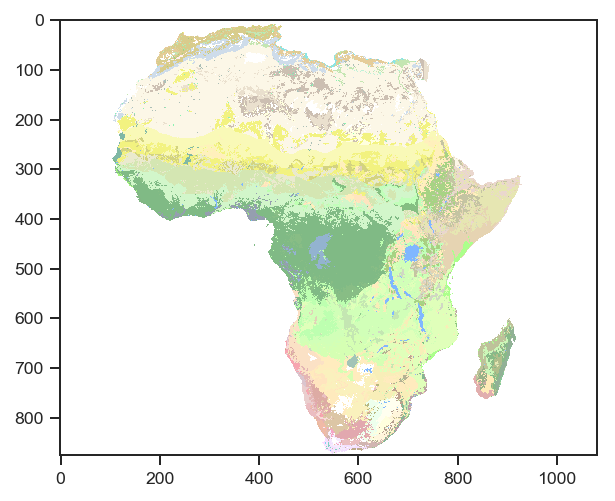

In [512]:
plt.imshow(data, cmap=color_map, alpha=0.5);

### plot with cartopy

In [513]:
extent_lonlat = (
    origin_x, 
    origin_x + (pixel_width * dataset.RasterXSize),
    origin_y + (pixel_height * dataset.RasterYSize),
    origin_y
)

In [514]:
crs_lonlat = ccrs.PlateCarree()

In [515]:
#drop CM transect
df.drop("CMgam_savanna", axis=0, inplace=True)
df.drop("CMgam_transition", axis=0, inplace=True)
df.drop("CMgam_forest", axis=0, inplace=True)

In [516]:
df.reset_index(inplace=True)
#make lonlat offsets, label position exceptions 
df['offset_lon'] = np.zeros(len(df))
df['offset_lat'] = np.zeros(len(df))
df['label'] = 'top'

#ghana col
df.loc[df['pop'] == 'GHcol', 'offset_lat'] = -3
df.loc[df['pop'] == 'GHcol', 'offset_lon'] = -2.6
#df.loc[df['pop'] == 'GHcol', 'label'] = 'bottom'
#ghana gam
df.loc[df['pop'] == 'GHgam', 'offset_lat'] = -3
df.loc[df['pop'] == 'GHgam', 'offset_lon'] = 2.6
#df.loc[df['pop'] == 'GHgam', 'label'] = 'bottom'
#BFgam
df.loc[df['pop'] == 'BFgam', 'offset_lat'] = 3
df.loc[df['pop'] == 'BFgam', 'offset_lon'] = 2.6
df.loc[df['pop'] == 'BFgam', 'label'] = 'bottom'
#BFcol
df.loc[df['pop'] == 'BFcol', 'offset_lat'] = 3
df.loc[df['pop'] == 'BFcol', 'offset_lon'] = -2.6
df.loc[df['pop'] == 'BFcol', 'label'] = 'bottom'

#Uganda
df.loc[df['pop'] == 'UGgam', 'offset_lat'] = 3
df.loc[df['pop'] == 'UGgam', 'offset_lon'] = 0
df.loc[df['pop'] == 'UGgam', 'label'] = 'bottom'
#Gambia
df.loc[df['pop'] == 'GM', 'offset_lat'] = 0
df.loc[df['pop'] == 'GM', 'offset_lon'] = -3
df.loc[df['pop'] == 'GM', 'label'] = 'bottom'
#GB
df.loc[df['pop'] == 'GW', 'offset_lat'] = -2
df.loc[df['pop'] == 'GW', 'offset_lon'] = -2
#Kenya
df.loc[df['pop'] == 'KE', 'offset_lat'] = -1
df.loc[df['pop'] == 'KE', 'offset_lon'] = 2
df.loc[df['pop'] == 'KE', 'label'] = 'bottom'
#Cam
df.loc[df['pop'] == 'CMgam', 'offset_lat'] = 3
df.loc[df['pop'] == 'CMgam', 'offset_lon'] = 3
df.loc[df['pop'] == 'CMgam', 'label'] = 'bottom'
#mayotte
df.loc[df['pop'] == 'FRgam', 'offset_lat'] = 2
df.loc[df['pop'] == 'FRgam', 'offset_lon'] = -1
df.loc[df['pop'] == 'FRgam', 'label'] = 'bottom'
#Equatorial Guinea
df.loc[df['pop'] == 'GQgam', 'offset_lat'] = -1
df.loc[df['pop'] == 'GQgam', 'offset_lon'] = -2
df.loc[df['pop'] == 'GQgam', 'label'] = 'bottom'
#Angola
df.loc[df['pop'] == 'AOcol', 'offset_lat'] = 0
df.loc[df['pop'] == 'AOcol', 'offset_lon'] = -3
#Gabon
# df.loc[df['pop'] == 'Gabon', 'offset_lat'] = -1.5
# df.loc[df['pop'] == 'Gabon', 'offset_lon'] = 3
df.loc[df['pop'] == 'GAgam', 'offset_lat'] = -2
df.loc[df['pop'] == 'GAgam', 'offset_lon'] = -2.5
#Guinea
df.loc[df['pop'] == 'GN', 'offset_lat'] = 2
df.loc[df['pop'] == 'GN', 'offset_lon'] = -1
df.loc[df['pop'] == 'GN', 'label'] = 'bottom'
# #Guinea
# df.loc[df['pop'] == 'Guinea', 'offset_lat'] = 2
# df.loc[df['pop'] == 'Guinea', 'offset_lon'] = -1
#Cote
df.loc[df['pop'] == "CIcol", 'offset_lat'] = 2
df.loc[df['pop'] == "CIcol", 'offset_lon'] = -2.5
#df.loc[df['pop'] == "CIcol", 'label'] = 'bottom'

In [517]:
df

,pop,F1,F2,F3,F4,F5,S1,S2,S3,S4,...,OR,wt,other,total,lon,lat,other_resistant,offset_lon,offset_lat,label
0,AOcol,111,0,0,0,0,0,0,0,0,...,20,25,0,156,13.291000,-8.821000,NaN,-3.0,0.0,top
1,GHcol,90,0,0,0,0,0,0,0,0,...,0,20,0,110,-1.317371,5.377246,NaN,-2.6,-3.0,top
2,BFcol,123,0,0,0,0,0,0,0,0,...,5,22,0,150,-4.461400,11.222600,NaN,-2.6,3.0,bottom
3,CIcol,125,0,0,0,0,0,0,0,0,...,5,12,0,142,-4.822930,5.898390,NaN,-2.5,2.0,top
4,CMgam,28,13,55,23,159,0,8,0,37,...,40,189,0,594,13.936182,4.936394,NaN,3.0,3.0,bottom
5,GHgam,24,0,0,0,0,0,0,0,0,...,0,0,0,24,-0.219280,5.668490,NaN,2.6,-3.0,top
6,BFgam,183,0,0,0,0,0,0,0,0,...,1,0,0,184,-4.371304,11.192065,NaN,2.6,3.0,bottom
7,GN,86,0,0,0,0,0,0,0,0,...,0,1,0,88,-9.692000,8.912500,1.0,-1.0,2.0,bottom
8,GW,0,0,0,0,0,0,0,0,0,...,0,182,0,182,-15.606377,11.914894,NaN,-2.0,-2.0,top
9,GM,0,0,0,0,0,0,0,0,0,...,0,130,0,130,-15.900000,13.550000,NaN,-3.0,0.0,bottom


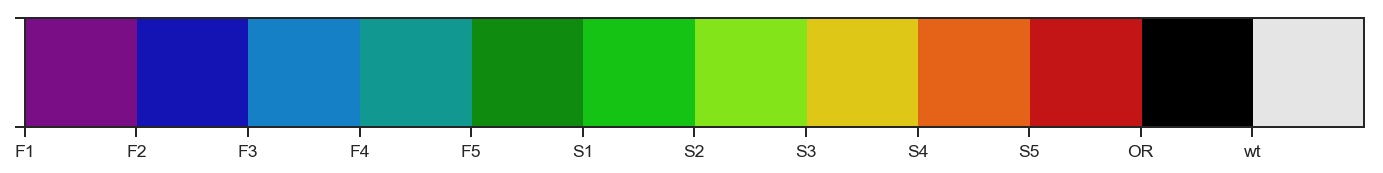

In [518]:
palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels) - 2, desat=0.8)
# add a colour for other_resistant
palette.append((0, 0, 0))
# add a colour for wt 
palette.append((0.9, 0.9, 0.9))
# check
sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

In [519]:
# for legend
f_colors = {l: c for l, c in zip(hap_labels, palette)}
f_colors

{'F1': (0.47488509803921597, 0.05869215686274509, 0.5282294117647058),
 'F2': (0.07882686274509798, 0.07882686274509798, 0.7094417647058824),
 'F3': (0.08667000000000002, 0.5039405882352944, 0.78003),
 'F4': (0.06667000000000001, 0.60003, 0.5686417647058825),
 'F5': (0.061306862745098, 0.5517617647058823, 0.061306862745098),
 'S1': (0.08536215686274506, 0.7682594117647059, 0.08536215686274506),
 'S2': (0.5140988235294116, 0.9, 0.09999999999999998),
 'S3': (0.8752817647058824, 0.781164117647059, 0.09725352941176468),
 'S4': (0.9, 0.39176470588235296, 0.09999999999999998),
 'S5': (0.7682594117647059, 0.08536215686274506, 0.08536215686274506),
 'OR': (0, 0, 0),
 'wt': (0.9, 0.9, 0.9)}

In [520]:
def plot_shiny_map(fn=None, dpi=150):
    subplot_kw = dict(projection=crs_lonlat)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=subplot_kw)
    ax.set_extent(extent_lonlat, crs=crs_lonlat)
    ax.imshow(data, cmap=color_map, extent=extent_lonlat, origin='upper', alpha=0.3)
    ax.coastlines(resolution='50m', linewidth=1.5, zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=1.5, zorder=4)
    
    
    
        #add pies
    for _, row in df.iterrows():
        ratios = np.asarray([row[k]/row.total for k in hap_labels])
        ratios = np.append(ratios, 1 - np.sum(ratios))
       
        # wedgeprops is used here just to pass the zorder command
        centre = (row.lon + row.offset_lon, row.lat + row.offset_lat)
        radius = np.sqrt(row.total * .02)
        #radius=1.5
        
        ax.pie(ratios, wedgeprops=dict(zorder=7, linewidth=0), colors=palette, center=centre, radius=radius, shadow=True)
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=2))

        
        lbl = row['pop']
        if row.label == 'bottom':
            ax.text(centre[0], centre[1] + (radius + (0.1 * radius)), lbl, ha='center', va='bottom', fontsize=12, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)
        if row.label == 'top':
            ax.text(centre[0], centre[1] - (radius + (0.1 * radius)), lbl, ha='center', va='top', fontsize=12, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)
   
        if row.offset_lat != 0 or row.offset_lon != 0:
            ax.plot([row.lon, row.lon + row.offset_lon],[row.lat, row.lat + row.offset_lat], 'k-', lw=2, zorder=5)
    
        
    #cover tiny island
    plt.plot([-15, -5],[-5, -30], 'w', lw=20, zorder=2)
    ax.set_extent([-22, 48, -12, 15])

    handles = [mpl.patches.Patch(facecolor=f_colors[k], edgecolor='k', label=k) for k in hap_labels]
    leg = ax.legend(handles=handles, bbox_to_anchor=(0, 0), loc='lower left', title='Haplotype\ngroup', ncol=2, prop={'size': 11})
    #leg._legend_box.align = "left"
    
    
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight');

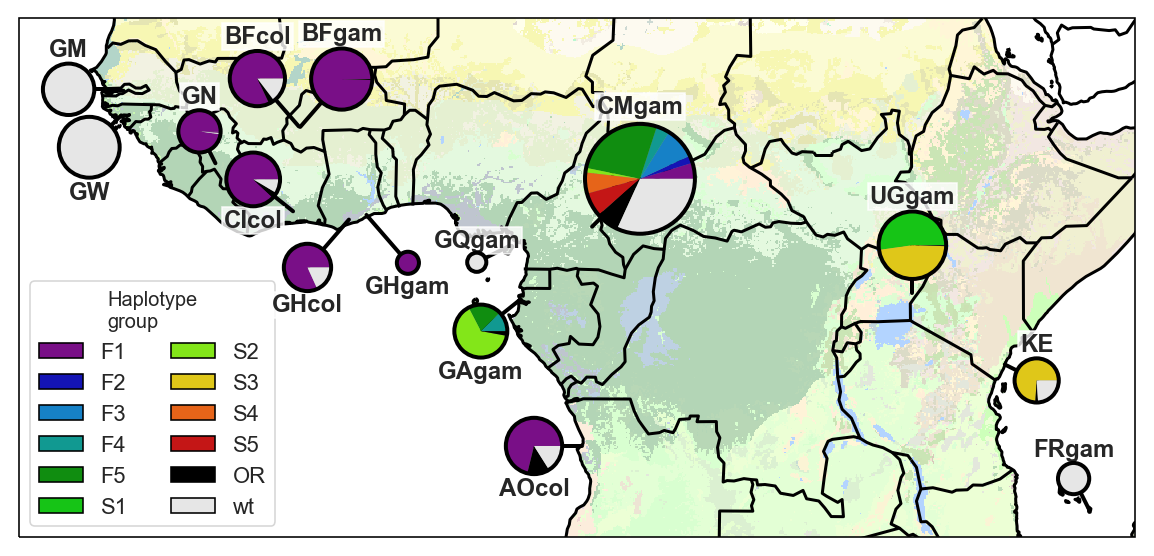

In [521]:
plot_shiny_map(fn='../artwork/figure_Phase_2_vgsc_haplotype_frequency.jpg')